# Hands-On NLP — Class 2

<span style="color:magenta">Group members:</span>

* Carlos Cuevas Villarmín
* Javier Alejandro Lopetegui González
* José Felipe Espinosa Orjuela

## Outline

- Embeddings from scratch

- Classifications with embeddings

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn import (
    decomposition,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    multiclass,
    naive_bayes,
    neighbors,
    svm,
    tree,
)
#import pca
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

nltk.download("punkt")

print("sklearn", sklearn.__version__)   # 1.3.2

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 2)

sklearn 1.3.0


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/javierlopetegui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
%config InlineBackend.figure_format="retina"  # For high DPI display

# %load_ext blackcellmagic

In [4]:
DATA = Path("../data")

TEXT_P = DATA / "texts"

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

## Getting the data

In [5]:
corpora = {}
stats = []

for corpus in tqdm(CORPORA):
    print(corpus)
    texts = []
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            texts.append(f.read())

    corpora[corpus] = "".join(texts)

    stats.append(
        {
            "corpus": corpus,
            "files_n": len(texts),
            "chars_n": len(corpora[corpus]),
        }
    )

df = pd.DataFrame.from_records(stats, index=["corpus"])
df["text"] = [corpora[corpus] for corpus in corpora]
df

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


,files_n,chars_n,text
corpus,,,
mythology,1428,4689305,Q:\n\nCan anyone identify what Chinese mytholo...
woodworking,2461,6729416,Q:\n\nGlue-up for butcher block-style countert...
robotics,2981,7254006,Q:\n\nHow is this torque value arrived?\n\nI'm...
hsm,2329,7364214,"Q:\n\nWhen and why did people stopped using ""n..."
health,3412,9148631,Q:\n\nHelp reading an eyeglass prescription: W...
portuguese,1840,4415251,"Q:\n\nQual a origem da expressão ""o fim da pic..."


### Tokenizing

In [6]:
# If your machine is slow, pickeling allows to go faster next time.

tokens_fp = DATA / "tokens.pkl"
try:
    tokens = pd.read_pickle(tokens_fp)
except FileNotFoundError:
    tokens = df.text.progress_map(word_tokenize)
    tokens.to_pickle(tokens_fp)

In [7]:
df["tokens"] = tokens
df["tokens_n"] = df.tokens.map(len)
df["types_n"] = df.tokens.map(set).map(len)
df

,files_n,chars_n,text,tokens,tokens_n,types_n
corpus,,,,,,
mythology,1428,4689305,Q:\n\nCan anyone identify what Chinese mytholo...,"[Q, :, Can, anyone, identify, what, Chinese, m...",942599,51253
woodworking,2461,6729416,Q:\n\nGlue-up for butcher block-style countert...,"[Q, :, Glue-up, for, butcher, block-style, cou...",1390532,32318
robotics,2981,7254006,Q:\n\nHow is this torque value arrived?\n\nI'm...,"[Q, :, How, is, this, torque, value, arrived, ...",1526904,53833
hsm,2329,7364214,"Q:\n\nWhen and why did people stopped using ""n...","[Q, :, When, and, why, did, people, stopped, u...",1445136,62464
health,3412,9148631,Q:\n\nHelp reading an eyeglass prescription: W...,"[Q, :, Help, reading, an, eyeglass, prescripti...",1714931,66006
portuguese,1840,4415251,"Q:\n\nQual a origem da expressão ""o fim da pic...","[Q, :, Qual, a, origem, da, expressão, ``, o, ...",907242,60282


## Vectorization

### 🚧 TODO: How to vectorize text?

- Try counting words in the stackoverflow corpus based on a given vocabulary

- Apply reduction techniques to reduce the dimensionality to 2 dimensions (e.g., PCA)

- Plot the 2D vectors

In [8]:
words = (
    "myth,wood,robot,history,science,mathematics,health,portuguese,o".split(",")
)

wc_df = pd.DataFrame(index=df.index)
for w in words:
    wc_df[w] = df.tokens.map(lambda x:x.count(w))


In [9]:
wc_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,769,55,6,179,21,4,18,0,27
woodworking,5,7535,0,18,9,0,48,0,2
robotics,0,21,4895,23,22,43,3,0,63
hsm,26,14,2,921,846,1578,28,1,25
health,46,10,1,207,114,6,1576,1,3
portuguese,2,11,3,13,3,1,8,41,14589


In [10]:
pca_model = PCA(n_components=2, random_state=42)
wc_df_pca = pca_model.fit_transform(wc_df)
wc_df_pca

array([[-2172.11807505, -1204.418861  ],
       [-3185.9537627 ,  5969.32416384],
       [-2446.45160229, -2479.24649585],
       [-2214.38228703, -1352.87210068],
       [-2215.38517532, -1297.79394626],
       [12234.29090238,   365.00723994]])

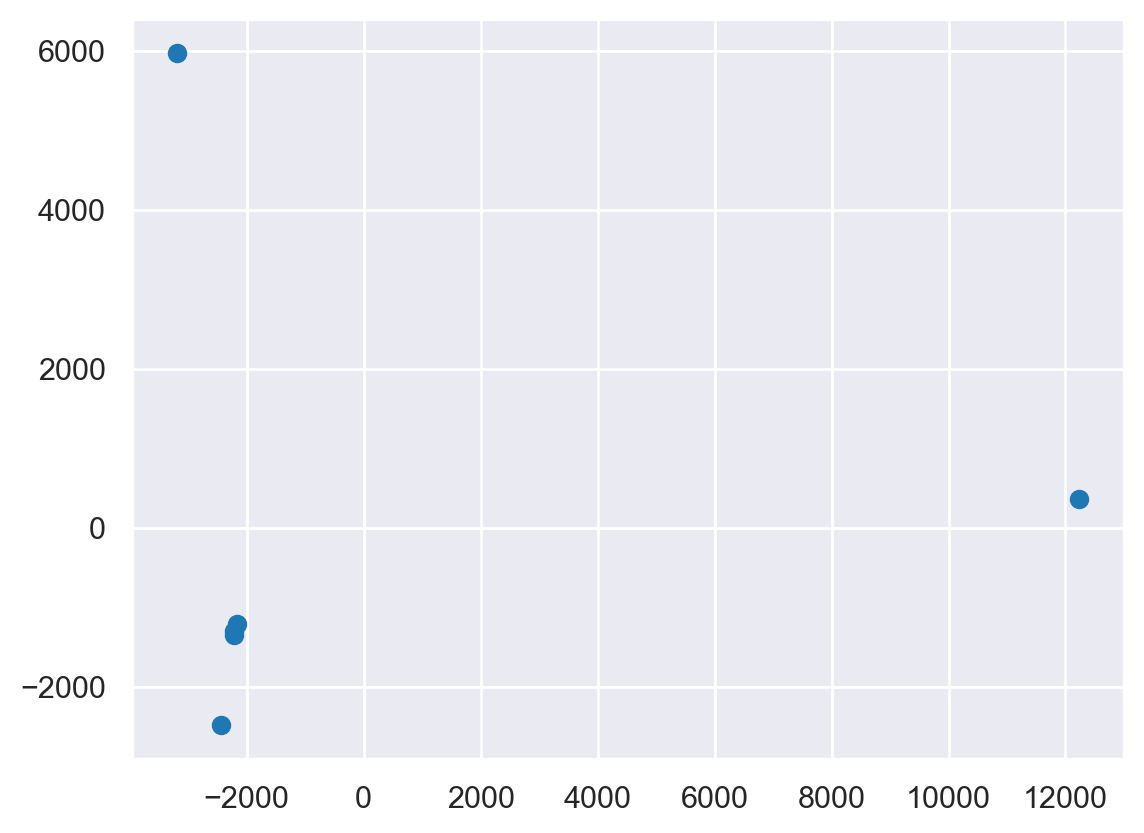

In [11]:
plt.scatter(wc_df_pca[:,0],wc_df_pca[:,1])

#### Bag of words

### 🚧 TODO: Implement another bag of words vectorizer model on the corpus

*   This time using [sklearn's `CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

*   Try first the provided example in the `CountVectorizer` documentation

    Try with and without the n-gram parameter

*   Then try to vectorize the stackoverflow corpus using `vocabulary=words`

#### First with a toy example

In [12]:
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

With the whole vocabulary

In [13]:
vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())
print(xs.toarray())

vectorizer_2g = CountVectorizer(analyzer='word', ngram_range=(2,2))
x2gs = vectorizer_2g.fit_transform(corpus)

print(vectorizer_2g.get_feature_names_out())
print(x2gs.toarray())

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
['and this' 'document is' 'first document' 'is the' 'is this'
 'second document' 'the first' 'the second' 'the third' 'third one'
 'this document' 'this is' 'this the']
[[0 0 1 1 0 0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 1 1 0 1 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1]]


In [14]:
cv_df = pd.DataFrame(xs.toarray(), columns=vectorizer.get_feature_names_out())
cv_df.insert(0, "Document", corpus)
cv_df

,Document,and,document,first,is,one,second,the,third,this
0,This is the first document.,0,1,1,1,0,0,1,0,1
1,This document is the second document.,0,2,0,1,0,1,1,0,1
2,And this is the third one.,1,0,0,1,1,0,1,1,1
3,Is this the first document?,0,1,1,1,0,0,1,0,1


With a subset of the vocabulary

In [15]:
vocabulary = ["and", "document", "first"]
vectorizer = CountVectorizer(vocabulary=vocabulary)
x_fix_voc = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
print(x_fix_voc.toarray())

['and' 'document' 'first']
[[0 1 1]
 [0 2 0]
 [1 0 0]
 [0 1 1]]


#### Reprocess the stackoverflow corpora with `CountVectorizer`

In [16]:
vectorizer = CountVectorizer(vocabulary=words)

wc_cv = pd.DataFrame(index=df.index)
wc_cv = vectorizer.fit_transform(df.text)
wc_cv_df = pd.DataFrame(wc_cv.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
wc_cv_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,867,75,6,307,35,4,23,4,0
woodworking,5,8017,1,19,16,0,53,0,0
robotics,0,22,5321,25,33,50,3,2,0
hsm,28,17,2,1513,1174,2095,39,7,0
health,55,13,1,242,263,9,2178,4,0
portuguese,2,13,3,18,7,3,9,1061,0


In [17]:
pca_model_cv = PCA(n_components=2, random_state=42)
wc_df_pca_cv = pca_model_cv.fit_transform(wc_cv_df)
wc_df_pca_cv

array([[-1032.50221868,  -988.52177405],
       [ 6729.59882928,   532.64469612],
       [-2169.27689764,  4142.59953674],
       [-1271.05580578, -1471.11168456],
       [-1171.62334588, -1239.49820279],
       [-1085.14056131,  -976.11257146]])

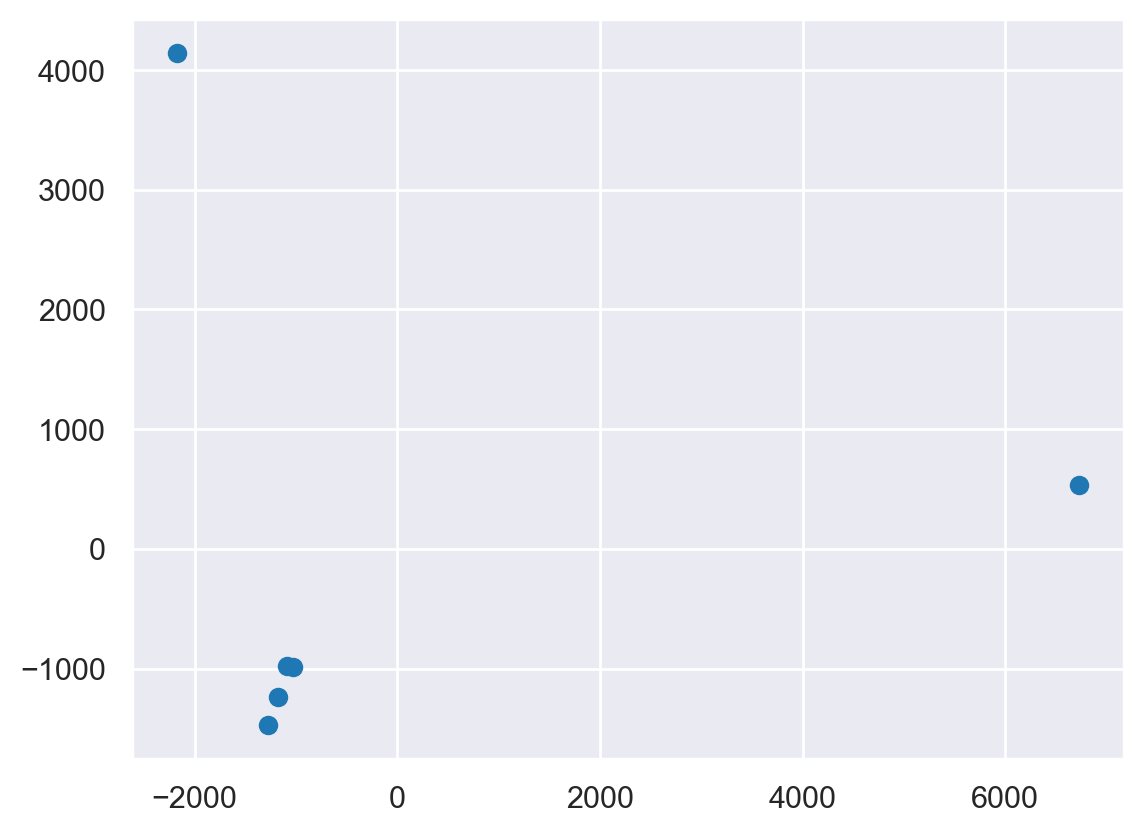

In [18]:
plt.scatter(wc_df_pca_cv[:,0],wc_df_pca_cv[:,1])

#TODO: Put labels for each point to analize whic datasets are more similar

### 🚧 TODO: Why is this different? 

- Try to explain

- Give a simple example with the toy corpus below (with the same vocabulary)

In [ ]:
test_text = (
    "myth wood robot history science mathematics health portuguese o "
    "myth wood robot history science mathematics health portuguese o"
)

# freqs = ...

# test_wc_df = ...

In [ ]:
# test_xs = vectorizer...

# test_cv_df = ...

### 🚧 TODO: Is this difference important?

• Visualize the PCAs of both models

-----------

### Now let's hold the corpus as individual documents

In [19]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [61]:
doc_df = pd.DataFrame.from_records(data).set_index("id")
doc_df.head()

,text,category,cat_id,tokens_n
id,,,,
woodworking.stackexchange_0000001080,Q:\n\nHow to remove dust after sanding before ...,woodworking,1,711
portuguese.stackexchange_0000004801,"Q:\n\nAlguma boa tradução para ""busk""?\n\nVi e...",portuguese,5,402
portuguese.stackexchange_0000001479,"Q:\n\n""algumas pessoas choram, e outras vendem...",portuguese,5,589
hsm.stackexchange_0000006406,Q:\n\nWhat is the name of this numeral system?...,hsm,3,309
portuguese.stackexchange_0000006188,"Q:\n\nDizer que um vernáculo é um vernáculo, é...",portuguese,5,284
...,...,...,...,...
robotics.stackexchange_0000022429,Q:\n\nDid I buy the wrong SBR rails?\n\nI have...,robotics,2,228
portuguese.stackexchange_0000001322,"Q:\n\nDiferença entre ""terráqueo"", ""terrestre""...",portuguese,5,315
robotics.stackexchange_0000014785,Q:\n\nInverse kinematic orientation problem\n\...,robotics,2,505


#### 🚧 TODO: Plot (bar) the number of documents per category

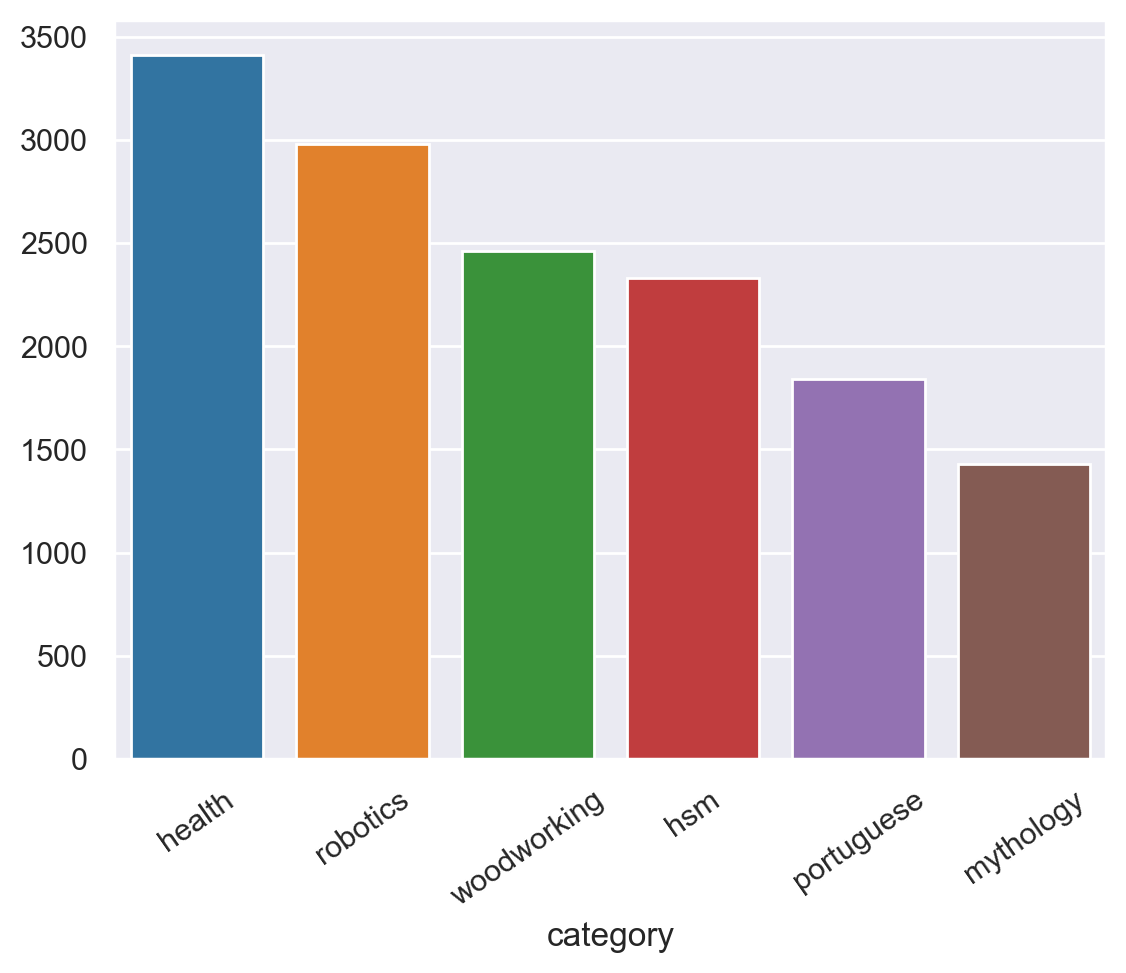

In [48]:
cat_count_df = doc_df['category'].value_counts()
sns.barplot(x=cat_count_df.index, y=list(cat_count_df))
plt.xticks(rotation=35)
plt.show()

#### 🚧 TODO: Boxplot the number of tokens per document

* With and without outliers

* Shortly explain the different values presented in a boxplot ([Wikipedia](https://en.wikipedia.org/wiki/Box_plot))

* Are the texts of signifcantly different length? Argue shortly.

  0%|          | 0/14451 [00:00<?, ?it/s]

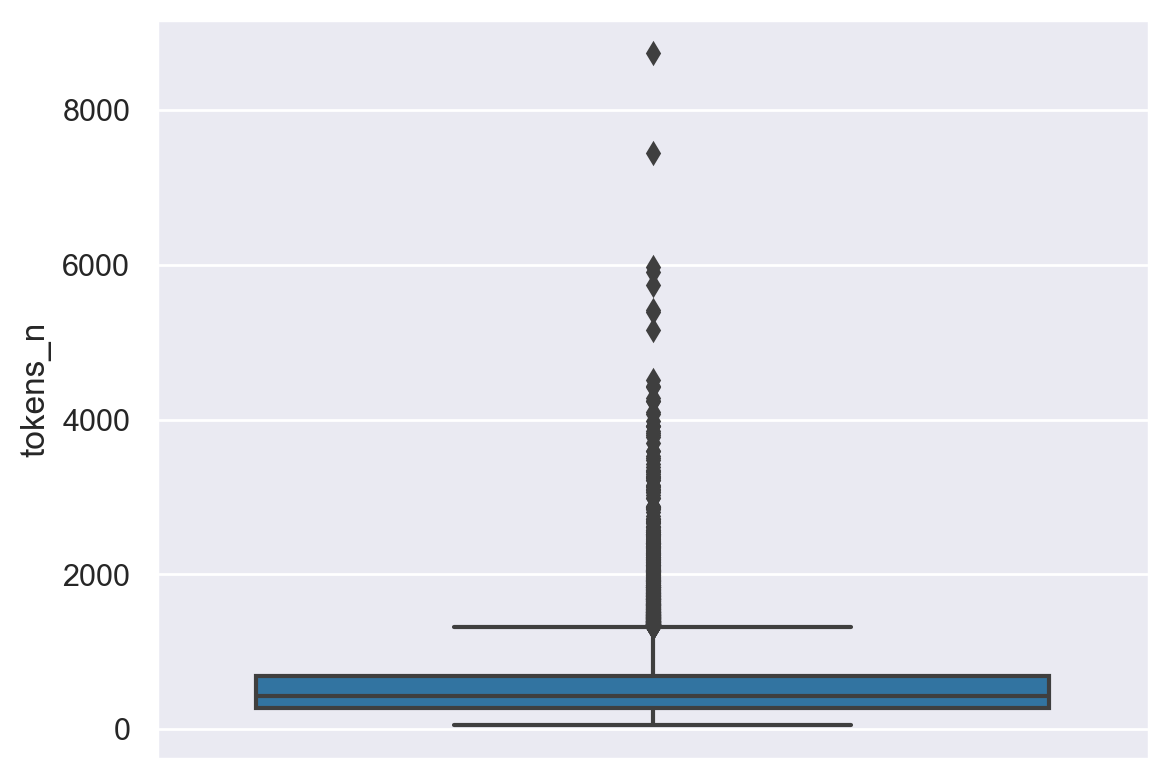

In [50]:
# Careful: slow!

doc_df["tokens_n"] = doc_df.text.progress_map(word_tokenize).map(len)
# boxplot with seaborn
sns.boxplot(y="tokens_n", data=doc_df)
# plt.xticks(rotation=35)
plt.show()

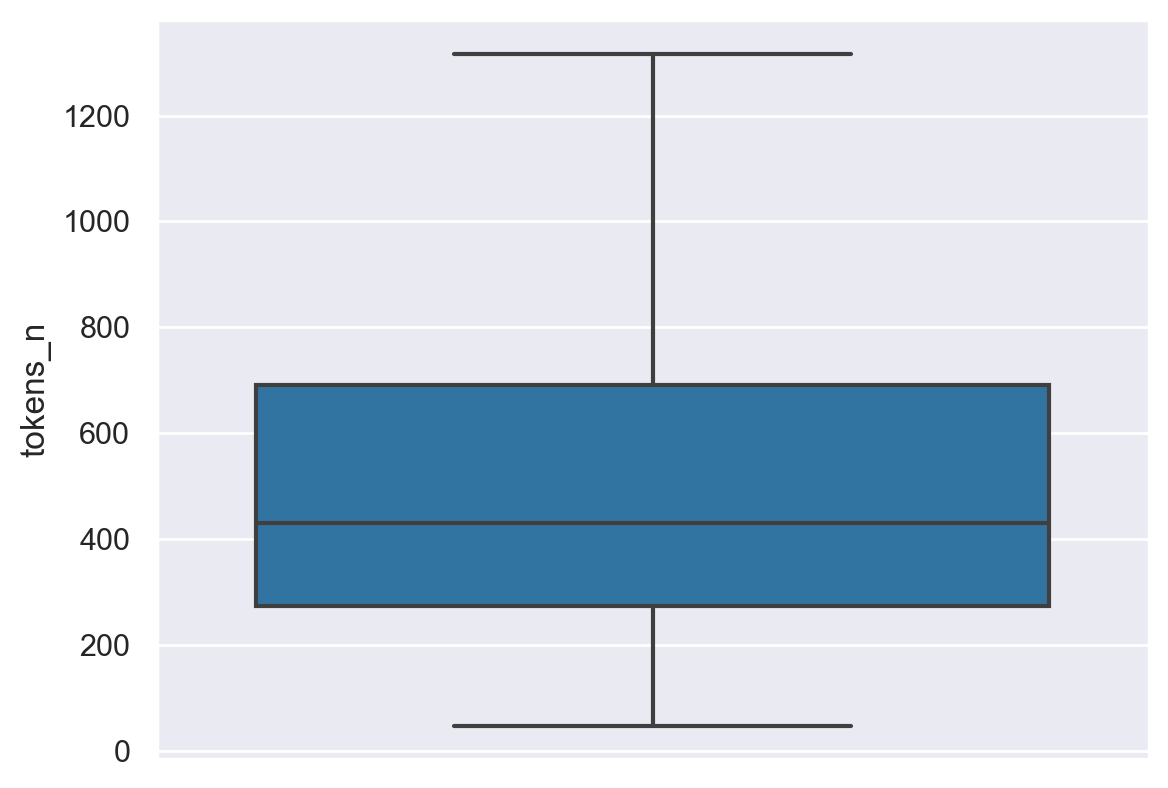

In [51]:
# plot without outliers
sns.boxplot(y="tokens_n", data=doc_df, showfliers=False)
plt.show()

In [53]:
# calculate the number of outliers and its ratio
q1 = doc_df["tokens_n"].quantile(0.25)
q3 = doc_df["tokens_n"].quantile(0.75)
iqr = q3 - q1
print("IQR:", iqr)
outliers = doc_df[(doc_df["tokens_n"] < q1 - 1.5 * iqr) | (doc_df["tokens_n"] > q3 + 1.5 * iqr)]
print("N_docs:", len(doc_df))
print("Outliers:", len(outliers))
print("Outliers ratio:", len(outliers) / len(doc_df))

IQR: 418.0
N_docs: 14451
Outliers: 712
Outliers ratio: 0.04926994671649021


#### 🚧 TODO: How to find the crazy long robotics text?

*   Find the index of the longest text

*   Show the content

*   Explain why this text is so long (what does it contain?)

In [60]:
longests_text = np.argmax(doc_df.tokens_n)
print(doc_df.text[longests_text])

Q:

6DOF Kinematics moveo

I asked on stackoverflow for the DH-Parameter for my robotic arm (moveo bcn3d).
I also copied the arduino code of Skyentific (YouTuber). Modified it to match my settings but i still does not work. Can someone please help me??? I am getting depressed if this keeps going like that.
In the home position, all joints have angle 0.
If I tell the forward kinematic that I want the 3rd joint and the 5th joint rotated 90 degrees, the values should be: (224, 0, 280) {x, y, z} should come out + some euler angles (can be ignored for now).
But I don't understand why these values come out, because the r and d values of the DH matrix are correct(https://stackoverflow.com/questions/67159164/denavit-hartenberg-6dof-moveo-inverse-kinematic-robot-arm?noredirect=1#comment118726837_67159164)
Output of the Arduino:\
inverse:
0.00
0.00
-0.00
-180.00
180.00
-180.00
forward:
-224.00
0.00
280.00
45.00
180.00
45.00
In this example you can see that the inverse kinematic calculates three 

/var/folders/s8/t5h89pw54h7f2nhm2mqdvzyc0000gn/T/ipykernel_51583/537770211.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(doc_df.text[longests_text])


**Why too large??**

We can explain the extremely large size of this text by its nature. In this case the user putted the entire code of its arduino implementation for a robotic arm movement system. It means that the tokenizer will find a lot of specific tokens for code and short tokens such as number and variables.

### Vectorizing again

#### 🚧 TODO: See how many features we get if we don't restrict their number

* Use again the `CountVectorizer` to vectorize the stackoverflow corpus

  * But use the whole vocabulary of the documents this time (**without** `vocabulary=words`)

  * Tell how many features are obtained

* Then limit the vocabulary to the 5000 most frequent words

* Apply and plot dimensionality reduction to 2 dimensions as prevously 
  (only on the limited vocabulary)

We want something like this:

```python
xs ~ doc_df.text
ys ~ doc_df.cat_id
```

In [63]:
ys = doc_df.cat_id.values
ys

array([1, 5, 5, ..., 2, 0, 3])

In [69]:
unconstrained_cv = CountVectorizer()
xs = unconstrained_cv.fit_transform(doc_df.text)
# print the number of features
print("N_features:", len(unconstrained_cv.get_feature_names_out()))

N_features: 153122


In [71]:
cv = CountVectorizer(max_features=5000)
xs = cv.fit_transform(doc_df.text)
print("N_features:", len(cv.get_feature_names_out()))

N_features: 5000


In [73]:
pca = PCA(n_components=2, random_state=42)
xs_pca = pca.fit_transform(xs.toarray())
xs_pca

array([[ 1.60352195e+01, -2.49699195e-01],
       [-3.25069691e+01, -2.16345141e-01],
       [-3.07977295e+01, -2.39320272e-01],
       ...,
       [-1.92899658e+01, -5.77559436e-02],
       [ 7.37635570e+01,  7.05124971e-02],
       [-5.36362168e+00,  1.34622797e-01]])

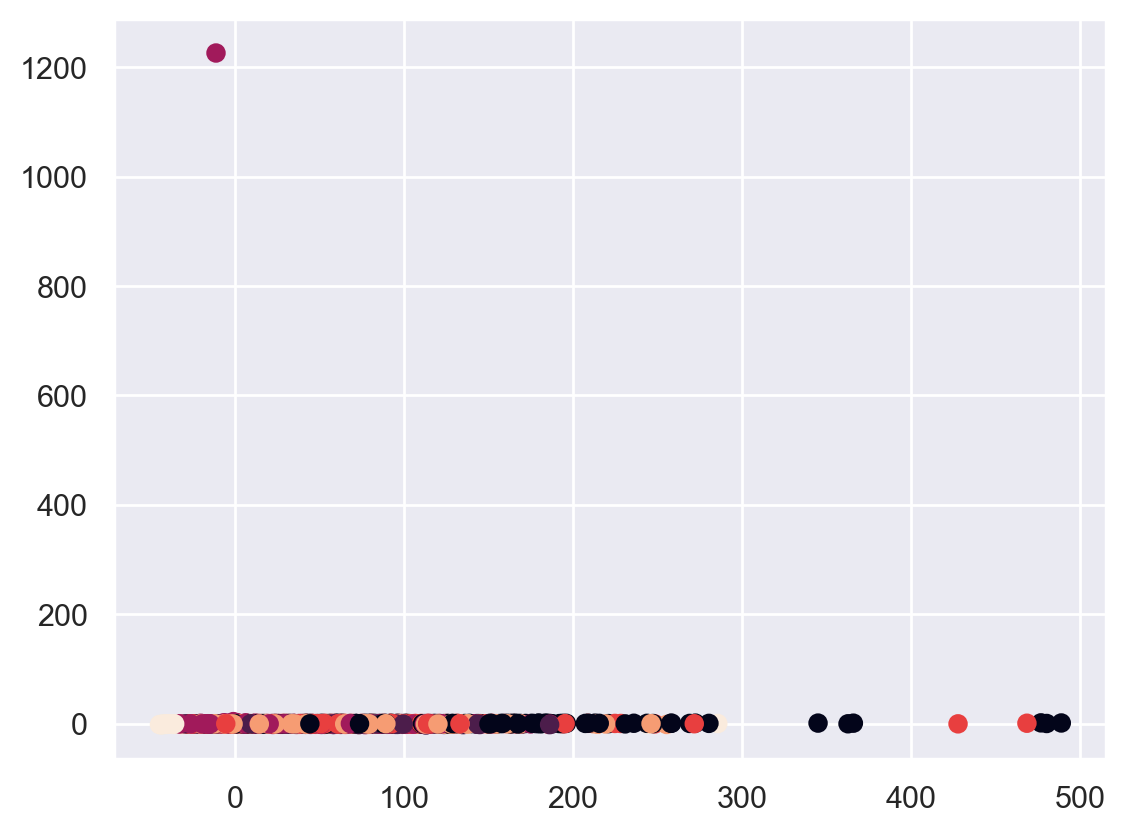

In [84]:
# scatter plot of the point with the correspondent legend
plt.scatter(xs_pca[:, 0], xs_pca[:, 1], c=ys)

#### 🚧 TODO: Find that outlier!

* Use pandas to find the document corresponding to the outlier

* Print the correspoding text
  
* Tell what it contains (if you could figure it out)

* Remove the corresping raw from the dataframe and redo the dimensional reduction (and plot)

In [91]:
# find the outlier in pca scatter plot using pandas
outlier = doc_df.iloc[np.argmax(xs_pca[:, 1])]
print(outlier)
print(outlier.text)

text        Q:\n\narduino -lcd screen has weird noise with...
category                                             robotics
cat_id                                                      2
tokens_n                                                 2570
Name: robotics.stackexchange_0000005103, dtype: object
Q:

arduino -lcd screen has weird noise with multiple pictures

I'm connecting an arduino to a lcd screen using the following library. For the display code I have written a simple piece of code that should display 2 picture os eyes (1 angry one friendly) and switching at regular intervals, however the display keeps showing me weird pixels around the borders that shouldn't be there, by making it show the same eyes twice this can be fixed however as long as I have both eyes being used it runs into trouble. Here is my code: 
    void setup()
    {
      LCDA.initDriverPin(2,7,10); 
      LCDA.Initialise(); // INIT SCREEN  
      delay(100);
    }
    void loop(){
      LCDA.CLEAR(); //empty 

## What does it contain??

In this case the text correspond to a question about an arduino connected to a LCD display that apparently has too much unexpected noise. Then, most of the text correspond to hexagesimal numbers that represent pixels in the screen.

#### 🚧 TODO: The reason for this outlier is...

*   Give a short explanation

*   Remove the outlier from the dataframe 

*   Redo the dimensional reduction

*   Plot the 2D vectors and color them by category

In [118]:
out_tokens = cv.transform([outlier.text])
# get tokens more frequent in outlier than in the rest of the corpus
print(out_tokens.count_nonzero())
# print tokens non zero
print(cv.get_feature_names_out()[out_tokens.indices])
print(f'The token {cv.get_feature_names_out()[out_tokens.indices][0]} appears {out_tokens[0, out_tokens.indices[0]]} times in the outlier text')
print(f'The token {cv.get_feature_names_out()[out_tokens.indices][1]} appears {out_tokens[0, out_tokens.indices[1]]} times in the outlier text')
print(f'The token {cv.get_feature_names_out()[out_tokens.indices][0]} appears {xs[:, out_tokens.indices[0]].sum()} times in the corpus')
print(f'The token {cv.get_feature_names_out()[out_tokens.indices][1]} appears {xs[:, out_tokens.indices[1]].sum()} times in the corpus')
print(f'The number of tokens in the outlier text is {out_tokens.sum()}')
print(f'The {(out_tokens[0, out_tokens.indices[0]] + out_tokens[0, out_tokens.indices[1]])/out_tokens.sum()} of the tokens in the outlier text are {cv.get_feature_names_out()[out_tokens.indices[0]]} or {cv.get_feature_names_out()[out_tokens.indices[1]]}')

147
['0x00' '0xfe' '10' '100' 'active' 'along' 'an' 'and' 'appear' 'arduino'
 'around' 'as' 'at' 'be' 'because' 'being' 'black' 'both' 'bottom' 'by'
 'byte' 'can' 'causing' 'changes' 'changing' 'clear' 'code' 'command'
 'connecting' 'creates' 'creating' 'cut' 'delay' 'different' 'display'
 'each' 'empty' 'even' 'eyes' 'face' 'few' 'finish' 'fit' 'fixed'
 'following' 'for' 'has' 'have' 'here' 'however' 'image' 'images' 'in'
 'intervals' 'into' 'is' 'it' 'just' 'keeps' 'kind' 'last' 'least'
 'library' 'lines' 'long' 'look' 'loop' 'making' 'me' 'memory' 'moving'
 'much' 'multiple' 'my' 'noise' 'not' 'note' 'of' 'on' 'one' 'ones' 'os'
 'other' 'out' 'patterns' 'picture' 'pictures' 'piece' 'problem'
 'problems' 'ran' 'random' 'rather' 're' 'regular' 'right' 'runs' 'same'
 'saved' 'screen' 'seconds' 'set' 'setup' 'should' 'shouldn' 'show'
 'showing' 'side' 'simple' 'size' 'so' 'solved' 'some' 'space' 'such'
 'suggesting' 'switching' 'that' 'the' 'them' 'themselves' 'then' 'there'
 'these' 't

We can see clearly from the results obtained in the last cell that this text is very different to the others. The tokens **0x00** and **0xfe** represent around the $84$ % of the tokens in this text. Furthermore, most of the appearances of these tokens are in this text, they just appear in the rest of the corpus 14 and 1 times respectively.

In [ ]:
# drop the outlier from the doc_df
doc_df.drop(outlier.name, inplace=True)
len(doc_df)

In [122]:
# pca over the data frame without the outlier
ys = doc_df.cat_id.values
cv = CountVectorizer(max_features=5000)
xs = cv.fit_transform(doc_df.text)
pca = PCA(n_components=2, random_state=42)
xs_pca = pca.fit_transform(xs.toarray())
xs_pca

array([[ 16.03444189, -12.0485271 ],
       [-32.5077907 ,  15.49195814],
       [-30.7985462 ,  16.09707001],
       ...,
       [-19.29073839,  -3.05497185],
       [ 73.76280189,   8.97171733],
       [ -5.36433235,   1.8813631 ]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


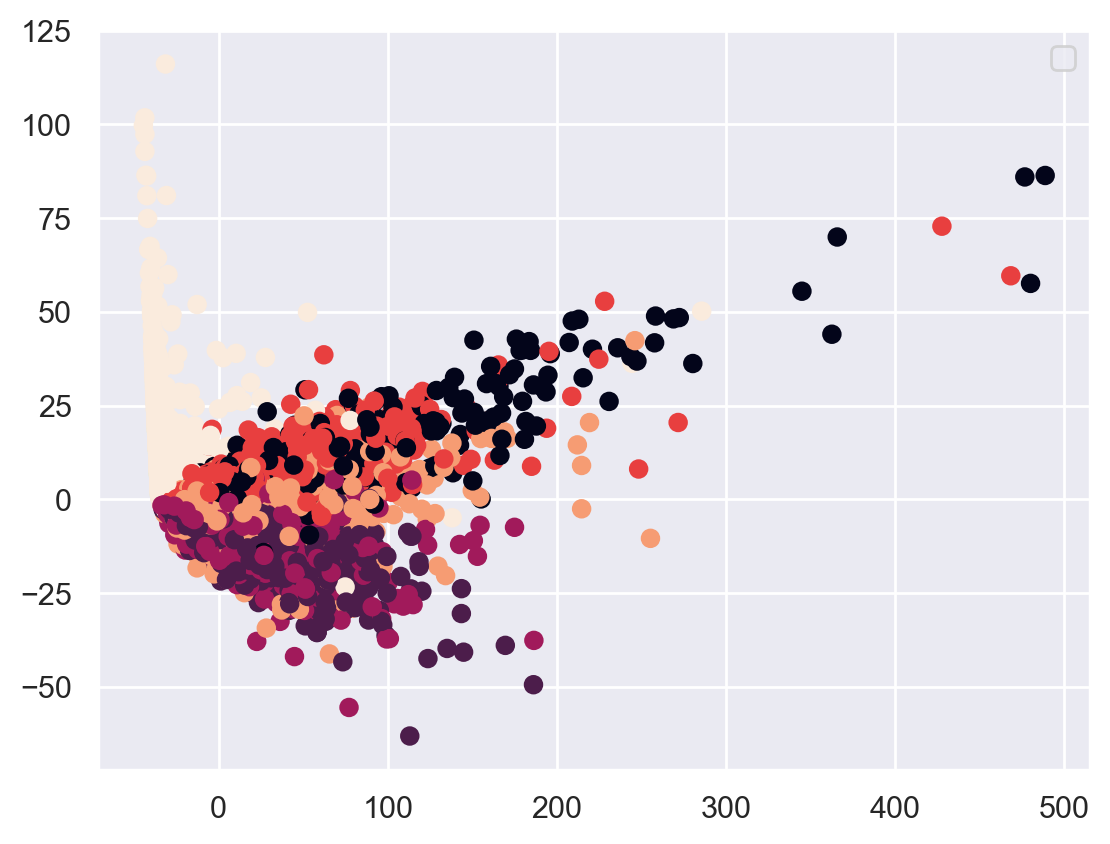

In [128]:
plt.scatter(xs_pca[:, 0], xs_pca[:, 1], c = ys)
plt.legend()
plt.show()

## Train models to predict text subjects

### Split the data in training and test sets

In [ ]:
train_xs, test_xs, train_ys, test_ys = model_selection.train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

### 🚧 TODO: Apply different algorithms to try predicting the category

* E.g., Logistic Regression, Multinomial Naive Bayes, Decision Tree Classifier, Random Forest, Support Vector Classifer.

* You could investigate [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), which implements linear classifiers (e.g, SVM, logistic regression) with SGD training (faster).

* Present a table with the results of the different algorithms (e.g., accuracy, precision, recall, f1-score) and their execution time

* (Optional) Analyse 1 algorythm in detail (e.g., Logistic Regression)

  *   Try different parameters (possibly with a grid search)

  *   Present the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

  *   Present the confusion matrix of the best model

### 🚧 TODO: Explain what model seems to work best

____